## New / Upgrade
This jupyter notebook creates plots to study the impact of adding new stations vs upgrading existing stations


### 0. Analysis IDs to compare

In [1]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (96, 97, )

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
#!pip install xarray

In [5]:
# Plotly for plotting 
#!pip install plotly

In [6]:
# Install psycopg2
#!pip install psycopg2-binary

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
import xarray as xr

### 2. Environment Variables

In [8]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [9]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'evidss'

### 3. Database connection

In [10]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [11]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [12]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [13]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [14]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,897,482
1,897,478
2,897,481
3,897,483
4,897,480
5,897,484
6,897,479


In [15]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,890,482
1,890,478
2,891,481
3,891,483
4,890,480
5,890,484
6,891,479


In [16]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,6,481
1,6,483
2,7,484
3,7,482
4,7,478
5,7,480
6,6,479


In [17]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,47.519479,-122.729338,484,0
1,47.182122,-121.035108,484,0
2,47.525862,-122.703977,484,0
3,47.650162,-117.441789,484,0
4,46.972660,-120.365347,484,0


In [18]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,105256.0,482
1,105244.0,478
2,105375.0,481
3,105366.0,483
4,105265.0,480
5,105230.0,484
6,105360.0,479


In [19]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,592,482
1,588,478
2,586,481
3,593,483
4,590,480
5,590,484
6,573,479


In [20]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,135,482
1,127,478
2,92,481
3,98,483
4,115,480
5,113,484
6,118,479


In [21]:
# basecase_aid = 438
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN (%s) UNION (select %s as analysis_id))
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,478,2019-07-01 06:00:15,0,1
1,479,2019-07-01 06:00:15,0,1
2,480,2019-07-01 06:00:15,0,1
3,478,2019-07-01 06:01:15,0,1
4,479,2019-07-01 06:01:15,0,1
...,...,...,...,...
3971,480,2019-07-02 04:48:15,0,1
3972,480,2019-07-02 04:49:15,0,1
3973,480,2019-07-02 04:50:15,0,1
3974,480,2019-07-02 04:51:15,0,1


In [22]:
sql_aids = """select analysis_id from analysis_record where set_id IN %s order by analysis_id"""
a_ids = pd.read_sql_query(sql=sql_aids, con=conn, params=(set_id,))['analysis_id'].tolist()
# a_ids = a_ids[:-1]
a_ids

[478, 479, 480, 481, 482, 483, 484]

In [23]:
bevse_df = pd.DataFrame(columns=['latitude', 'longitude', 'bevse_id', 'analysis_id'])
for a_id in a_ids: 
    sql_disabled_bevses = """select be.latitude, be.longitude, be.bevse_id
from built_evse be where dcfc_count > 0 and connector_code IN (1, 2, 3)
    except all
select en.latitude, en.longitude, cast(SUBSTRING(en.evse_id from 2) as double precision) as bevse_id
from evses_now en
where analysis_id = %s"""
    disabled_bevses = pd.read_sql_query(sql=sql_disabled_bevses, con=conn, params=(a_id,))
    disabled_bevses['analysis_id'] = a_id
    # print(disabled_bevses)
    bevse_df = bevse_df.append(disabled_bevses)
    # print(bevse_df)

In [24]:
len(bevse_df)

0

In [25]:
# basecase_aid = 438
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s )
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
order by ets.analysis_id desc
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,))
#count_stats.sort_values(by=['analysis_id'], inplace=True)
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,897,484,0,890,105230.0,7,590,113
1,897,483,1,891,105366.0,6,593,98
2,897,482,1,890,105256.0,7,592,135
3,897,481,1,891,105375.0,6,586,92
4,897,480,1,890,105265.0,7,590,115
5,897,479,1,891,105360.0,6,573,118
6,897,478,1,890,105244.0,7,588,127


In [26]:
# count_stats.dtypes
# count_stats = count_stats.sort_values(by=['nevse_count'])
# count_stats

In [27]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2021-04-09 19:40:50.027680+00:00,484,2021-04-09 19:49:49.271384+00:00,2021-04-09 23:33:01.634601+00:00,# EV: 897,0,8.0,223.0
1,2021-04-08 20:16:05.296936+00:00,479,2021-04-08 20:37:07.811588+00:00,2021-04-09 00:26:43.677508+00:00,# EV: 897,1,21.0,229.0
2,2021-04-08 20:17:41.071287+00:00,480,2021-04-08 20:37:26.308768+00:00,2021-04-09 00:14:09.968380+00:00,# EV: 897,1,19.0,216.0
3,2021-04-08 20:15:11.748888+00:00,478,2021-04-08 20:36:59.167129+00:00,2021-04-09 00:49:05.272745+00:00,# EV: 897,1,21.0,252.0
4,2021-04-08 20:21:11.645184+00:00,483,2021-04-08 20:39:44.262801+00:00,2021-04-09 00:17:47.648015+00:00,# EV: 897,1,18.0,218.0
5,2021-04-08 20:20:39.832113+00:00,482,2021-04-08 20:39:49.116597+00:00,2021-04-09 00:05:39.110358+00:00,# EV: 897,1,19.0,205.0
6,2021-04-08 20:20:07.927048+00:00,481,2021-04-08 20:39:25.697385+00:00,2021-04-09 00:10:01.396433+00:00,# EV: 897,1,19.0,210.0


In [28]:
a_ids

[478, 479, 480, 481, 482, 483, 484]

In [35]:
sql_ev_info_484 = """select veh_id, analysis_id, simulation_ts, lat_val, lng_val, soc_val, prob_val, state_val, tocharge_val
 from ev_info
 where analysis_id = 484 order by simulation_ts"""
ev_info_484 = pd.read_sql_query(sql=sql_ev_info, con=conn)
ev_info_484

,veh_id,analysis_id,simulation_ts,lat_val,lng_val,soc_val,prob_val,state_val,tocharge_val
0,3330344,484,2019-07-01 06:00:15,48.961422,-122.729985,81.000,0.000,resting,False
1,3224539,484,2019-07-01 06:00:15,47.215403,-124.201799,83.000,0.000,resting,False
2,320843876,484,2019-07-01 06:00:15,48.240029,-122.455245,88.000,0.000,resting,False
3,329649225,484,2019-07-01 06:00:15,47.784123,-122.139646,81.000,0.000,resting,False
4,312626254,484,2019-07-01 06:00:15,46.973344,-123.819641,92.000,0.000,resting,False
...,...,...,...,...,...,...,...,...,...
484689,130190728,484,2019-07-02 03:12:15,47.298554,-122.184185,73.057,0.487,driving,False
484690,130190728,484,2019-07-02 03:13:15,47.301380,-122.198647,71.901,0.487,driving,False
484691,130190728,484,2019-07-02 03:14:15,47.303601,-122.213334,70.746,0.487,driving,False
484692,130190728,484,2019-07-02 03:15:15,47.304221,-122.216020,70.746,0.487,finished,False


In [36]:
ev_info_484.memory_usage().sum()

31505238

In [42]:
ev_info_484_g = ev_info_484.groupby(['veh_id'])
for i, g in ev_info_484_g:
    print(g)

           veh_id  analysis_id        simulation_ts    lat_val     lng_val  \
579     100693526          484  2019-07-01 06:00:15  48.495189 -122.612836   
1026    100693526          484  2019-07-01 06:01:15  48.495189 -122.612836   
2005    100693526          484  2019-07-01 06:02:15  48.495189 -122.612836   
3140    100693526          484  2019-07-01 06:03:15  48.495189 -122.612836   
3885    100693526          484  2019-07-01 06:04:15  48.495189 -122.612836   
...           ...          ...                  ...        ...         ...   
469207  100693526          484  2019-07-01 19:02:15  45.892918 -122.489928   
469410  100693526          484  2019-07-01 19:03:15  45.896156 -122.476538   
469562  100693526          484  2019-07-01 19:04:15  45.895758 -122.459693   
469687  100693526          484  2019-07-01 19:05:15  45.843674 -122.392210   
469869  100693526          484  2019-07-01 19:06:15  45.843674 -122.392210   

        soc_val  prob_val state_val  tocharge_val  
579      82

### 5. Plotting

#### 5.1 Vehicle Counts

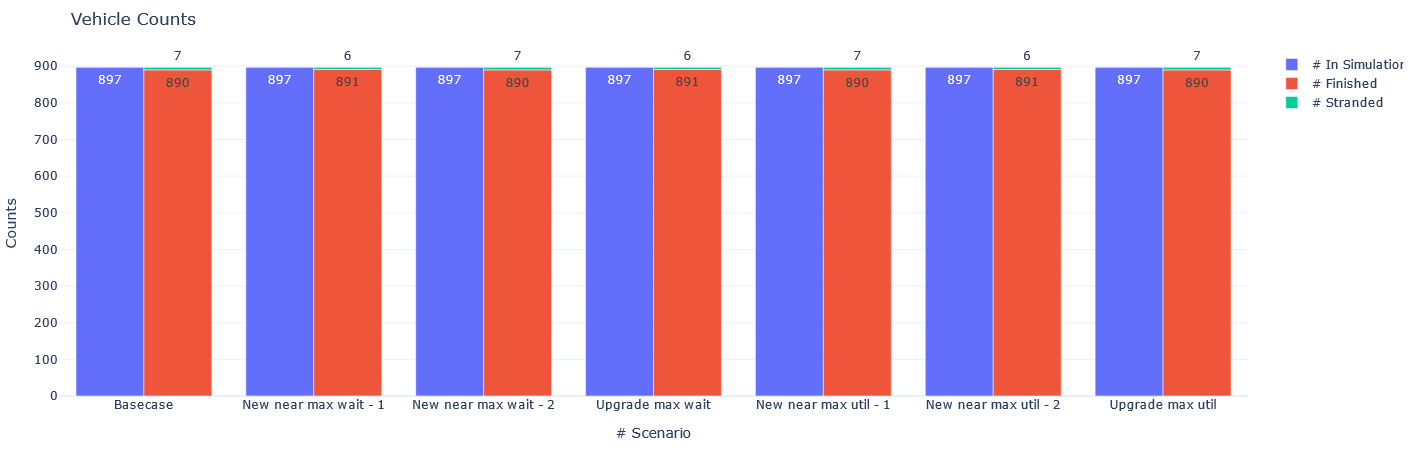

In [51]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['analysis_id'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['analysis_id'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['analysis_id'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=450
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5, 6], ticktext=['Basecase', 'New near max wait - 1', 'New near max wait - 2', 'Upgrade max wait', 'New near max util - 1', 'New near max util - 2', 'Upgrade max util'])
# fig.update_yaxes(range=(0, 1300))
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

## 5.2 eVMT

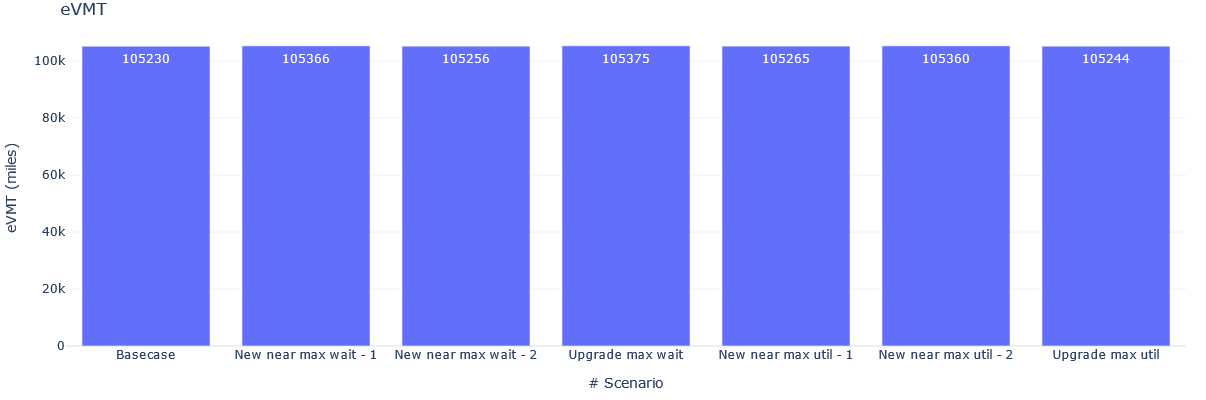

In [52]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['analysis_id'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="# Scenario", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5, 6], ticktext=['Basecase', 'New near max wait - 1', 'New near max wait - 2', 'Upgrade max wait', 'New near max util - 1', 'New near max util - 2', 'Upgrade max util'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

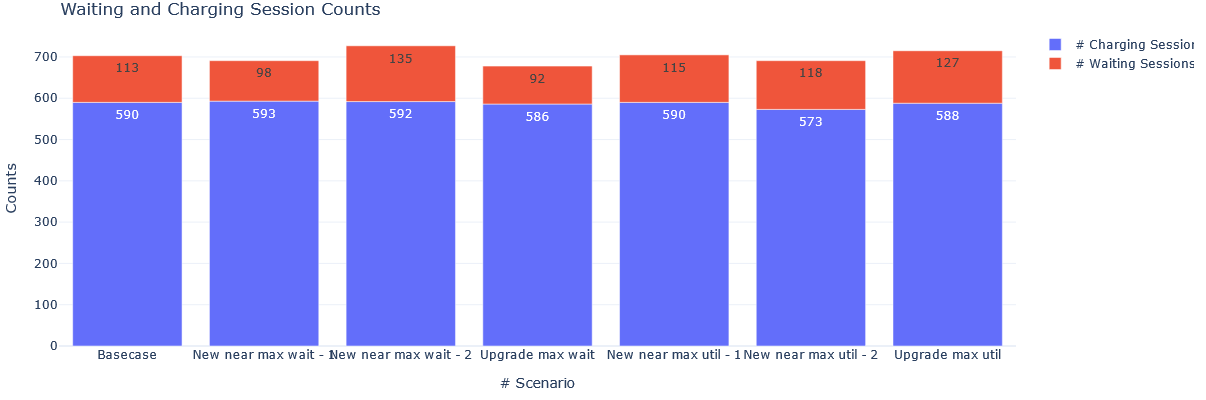

In [53]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5, 6], ticktext=['Basecase', 'New near max wait - 1', 'New near max wait - 2', 'Upgrade max wait', 'New near max util - 1', 'New near max util - 2', 'Upgrade max util'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

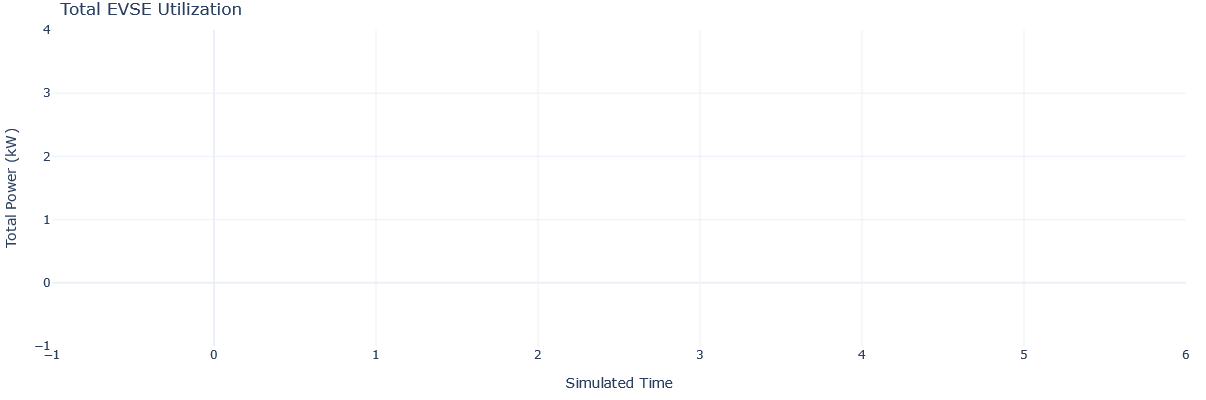

In [31]:
#fig = px.line(evse_util, x="datetime", y="total_power", color='analysis_id', name=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'], range_x=['2019-07-01 06:00','2019-07-02'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 465]['datetime'], y=evse_util[evse_util['analysis_id'] == 465]['total_power'],
                    mode='lines',
                    name='Basecase'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 466]['datetime'], y=evse_util[evse_util['analysis_id'] == 466]['total_power'],
                    mode='lines',
                    name='New + Up'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 467]['datetime'], y=evse_util[evse_util['analysis_id'] == 467]['total_power'],
                    mode='lines',
                    name='Only Up'))


fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white', showlegend=True, legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.9
))
fig.show()

In [32]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
# analysis_ids = new_evses['analysis_id'].unique()

In [33]:
len(bevse_df['analysis_id'].unique())

0

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. Will need NodeJS and NPM. If errors on NodeJS, then try on terminal.

In [34]:
#!jupyter labextension list

In [35]:
#!jupyter labextension uninstall jupyterlab-plotly

In [36]:
#!jupyter labextension uninstall plotlywidget

In [37]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [38]:
#!pip show plotly

In [39]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [40]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [41]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [42]:
#!pip install "nbconvert<6"